In [1]:
import numpy as np
import opendssdirect as dss
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

%matplotlib inline

# import numpy as np
# from matplotlib.mlab import PCA
from sklearn.decomposition import PCA

import scipy.linalg as spla

#######################################################
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5

SlackBusVoltage = 1.00

#######################################################
#######################################################


dss.run_command('Redirect feeder/05node_unbalanced_test.dss')
# dss.run_command('Redirect feeder/feeder34_B_NR/network_05node_3phase_radial.dss')

dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print(dss.Loads.AllNames())
print(len(dss.Loads.AllNames()))

print(dss.Circuit.AllBusNames())
print(len(dss.Circuit.AllBusNames()))

print('')

print(dss.RegControls.AllNames())

for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    
    print(dss.RegControls.TapNumber())
    
print('')

for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle()[::2])
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle()[::2])
    print('')

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
['spot_a1_a_01', 'spot_a1_b_01', 'spot_a1_c_01', 'spot_a2_ab_01', 'spot_a3_a_01', 'spot_a3_b_01', 'spot_a3_c_01', 'spot_a4_c_01']
8
['sourcebus', 'a0', 'a0r', 'a1', 'a2', 'a3', 'a4']
7

['reg1', 'reg2', 'reg3']
reg1
3
reg2
3
reg3
6

sourcebus
BASE - LN
132.79056191361394
VMAGANGLE - LN POLAR
[132789.98102538413, 132790.0479774935, 132789.64106473202]
puVMAGANGLE - LN POLAR
[0.9999956255307498, 0.9999961297240328, 0.9999930654041324]

a0
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2698.488275975769, 2700.4311993030797, 2650.1737499299074]
puVMAGANGLE - LN POLAR
[0.9737330828372871, 0.9744341749035607, 0.9562990799508201]

a0r
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2749.0111418441084, 2750.991649708597, 2749.436445190266]
puVMAGANGLE - LN POLAR
[0.9919639517181104, 0.9926786059360445, 0.9921174198439799]

a1
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2708.6373095653084, 2711.83554

In [2]:
# dss.Text.Command("new load.load_670_a_01 phases=1 bus1=702.1 conn=wye kV=4.16 kW=5400 kvar=200 model=1")

In [3]:
for k1 in range(len(dss.Loads.AllNames())):
    print(dss.Loads.AllNames()[k1])
    dss.Loads.Name(dss.Loads.AllNames()[k1])
    print(dss.CktElement.BusNames()[0])
    print(str.split(dss.CktElement.BusNames()[0],'.'))
    print(str.split(dss.CktElement.BusNames()[0],'.')[0])
    print('~')

spot_a1_a_01
a1.1
['a1', '1']
a1
~
spot_a1_b_01
a1.2
['a1', '2']
a1
~
spot_a1_c_01
a1.3
['a1', '3']
a1
~
spot_a2_ab_01
a2.1.3
['a2', '1', '3']
a2
~
spot_a3_a_01
a3.1
['a3', '1']
a3
~
spot_a3_b_01
a3.2
['a3', '2']
a3
~
spot_a3_c_01
a3.3
['a3', '3']
a3
~
spot_a4_c_01
a4.3
['a4', '3']
a4
~


In [4]:
for k1 in range(len(dss.Loads.AllNames())):
    print(dss.Loads.AllNames()[k1])
    dss.Loads.Name(dss.Loads.AllNames()[k1])
    print(dss.CktElement.BusNames()[0])
    print(str.split(dss.CktElement.BusNames()[0],'.'))
    dss.Circuit.SetActiveBus(dss.CktElement.BusNames()[0])
    print(dss.Bus.Nodes())
    print(dss.Bus.puVmagAngle()[::2])
    print('~~')

spot_a1_a_01
a1.1
['a1', '1']
[1, 2, 3]
[0.9773952998841215, 0.9785493649278254, 0.9689647679118705]
~~
spot_a1_b_01
a1.2
['a1', '2']
[1, 2, 3]
[0.9773952998841215, 0.9785493649278254, 0.9689647679118705]
~~
spot_a1_c_01
a1.3
['a1', '3']
[1, 2, 3]
[0.9773952998841215, 0.9785493649278254, 0.9689647679118705]
~~
spot_a2_ab_01
a2.1.3
['a2', '1', '3']
[1, 3]
[0.9769792356272926, 0.968763556751595]
~~
spot_a3_a_01
a3.1
['a3', '1']
[1, 2, 3]
[0.9705550793481179, 0.9717176487753072, 0.9544806330377038]
~~
spot_a3_b_01
a3.2
['a3', '2']
[1, 2, 3]
[0.9705550793481179, 0.9717176487753072, 0.9544806330377038]
~~
spot_a3_c_01
a3.3
['a3', '3']
[1, 2, 3]
[0.9705550793481179, 0.9717176487753072, 0.9544806330377038]
~~
spot_a4_c_01
a4.3
['a4', '3']
[3]
[0.9475069023333115]
~~


In [5]:
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Bus.Name())
    print(dss.Bus.Nodes())
    print(dss.Bus.puVmagAngle()[::2])
    print('~~~')

sourcebus
[1, 2, 3]
[0.9999956255307498, 0.9999961297240328, 0.9999930654041324]
~~~
a0
[1, 2, 3]
[0.9737330828372871, 0.9744341749035607, 0.9562990799508201]
~~~
a0r
[1, 2, 3]
[0.9919639517181104, 0.9926786059360445, 0.9921174198439799]
~~~
a1
[1, 2, 3]
[0.9773952998841215, 0.9785493649278254, 0.9689647679118705]
~~~
a2
[1, 3]
[0.9769792356272926, 0.968763556751595]
~~~
a3
[1, 2, 3]
[0.9705550793481179, 0.9717176487753072, 0.9544806330377038]
~~~
a4
[3]
[0.9475069023333115]
~~~


In [6]:
# for k1 in range(len(dss.Circuit.AllBusNames())):
#     dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
#     print(dss.Bus.Name())
#     print(dss.CktElement.Powers())
    

In [7]:
# for k1 in range(len(dss.Loads.AllNames())):
#     print(dss.Loads.AllNames()[k1])
#     dss.Loads.Name(dss.Loads.AllNames()[k1])
#     print(dss.CktElement.Powers())

In [54]:

class inverter():
    
    def __init__(self):
        
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        self.reactive_power = 0
    
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        self.wlp = 2*np.pi*0.10
        
        self.Vmeas = np.zeros(86401)
        self.Vlp = np.zeros(86401)
        
        self.reactive_power = np.zeros(86401)
        
        self.Ts = 1
        
        self.hackFlag = False
        
        self.pset = 0
        self.pout = 0
        
        self.qset = 0
        self.qout = 0
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
    def set_name(self, name):
        self.name = name
        
    def set_busnum(self, busnum):
        self.busnum = busnum
        
    def set_busname(self, busname):
        self.busname = busname
        
    def set_phase(self, phase):
        self.phase = phase
        
    def set_loadname(self, loadname):
        self.loadname = loadname
            
    def set_VBP(self, VBP):
        self.VBP = VBP
        
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
        
    def lowpass(self, kt):
        self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
        
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        # print(self.reactive_power)
        
    def set_active_power_setpoint(self, pset):
        self.pset = pset
        self.pout = self.pset
        
    def set_reactive_power_setpoint(self, qset):
        self.qset = qset
        self.qout = self.qset
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

# x1.measure_voltage(0,1.02)
# x1.measure_voltage(1,1.02)
# x1.measure_voltage(2,1.02)
# x1.measure_voltage(3,1.01)
# x1.measure_voltage(4,1.01)
# x1.measure_voltage(5,1.01)


print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[50.  0.  0. ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [63]:
#########################################################
################### RESTART OPENDSS #####################
#########################################################

dss.run_command('Redirect feeder/05node_unbalanced_test.dss')
dss.Solution.Solve()

if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')
    
for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    
    print(dss.RegControls.TapNumber())

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0

totalDayTimeSteps = 86401

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 3600

simStartTimeStep = 6*3600+1
simEndTimeStep = 18*3600+1

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 1200

simStartTimeStep = 12*3600+1 - 300
simEndTimeStep = 12*3600+1 + 600

time = np.arange(simStartTimeStep,simEndTimeStep)

totalSimTimeSteps = simEndTimeStep - simStartTimeStep + 1


AllBuses = dss.Circuit.AllBusNames()
numBuses = len(AllBuses)

AllLoads = dss.Loads.AllNames()
numLoads = len(AllLoads)

phlist = ['a', 'b', 'c', 'ab', 'bc', 'ca', 'abc']

##################################################
# Record nominal active and reactive power of loads in OpenDSS config
##################################################

PloadNominal = np.zeros(len(AllLoads))
QloadNominal = np.zeros(len(AllLoads))
lf = np.zeros(len(AllLoads))
for k1 in range(len(AllLoads)):
#     if 'inverter' not in AllLoads[k1]:
    dss.Loads.Name(AllLoads[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)

print('Load names')
print(AllLoads)
print('Nominal real power')
print(PloadNominal)
print('Nominal reactive power')
print(QloadNominal)
print('Load factor')
print(lf)

##################################################
# Set up inverter OpenDSS loads - single aggregate inverter load at each node
##################################################

# for k1 in range(len(AllBuses)):
#     if AllBuses[k1] != 'sourcebus':
#         print(AllBuses[k1])
#         dss.Circuit.SetActiveBus(AllBuses[k1])
#         for k2 in range(len(dss.Bus.Nodes())):
#             print(dss.Bus.Nodes()[k2])
#             namestr = 'new load.inverter_' + AllBuses[k1] + '_' + phlist[dss.Bus.Nodes()[k2]-1]
#             phstr = 'phases=1'
#             busstr = 'bus1=' + AllBuses[k1] + '.' + str(dss.Bus.Nodes()[k2])
#             connstr = 'conn=wye'
#             kVstr = 'kV=' + str(dss.Bus.kVBase())
#             loadstr = 'kW=0 kvar=0 model=1'

#             commstr = namestr + ' ' + phstr + ' ' + busstr + ' ' + connstr + ' ' + kVstr + ' ' + loadstr
#             print(commstr)

#             dss.Text.Command(commstr)
        
# AllLoads = dss.Loads.AllNames()
# AllBuses = dss.Circuit.AllBusNames()

##################################################
# Set up loads
##################################################

# Nload = 25
# Load_factored = Load/1.25

# load_indexes = np.zeros((len(AllBuses), Nload)).astype(int)
# for k1 in range(len(AllBuses)):
    
#     load_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Nload).astype(int)
# #     load_indexes[k1,:] = load_indexes[k1,:].astype(int)
# #     print(load_indexes[k1,:])

# # print(load_indexes)
# # print(Load_factored[load_indexes[0,:],0])


##################################################
# Set up generation
##################################################

# Ngen = 15
# Generation_factored = Generation/1.5

# generation_indexes = np.zeros((len(AllBuses), Ngen)).astype(int)
# for k1 in range(len(AllBuses)):
    
#     generation_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Ngen).astype(int)
# #     generation_indexes[k1,:] = generation_indexes[k1,:].astype(int)
# #     print(generation_indexes[k1,:])

# # print(generation_indexes)
# # print(Generation_factored[generation_indexes[0,:],0])




##################################################
# Set up inverter OpenDSS loads - separate load for each inverter
##################################################
       
inverters = []
for k1 in range(len(AllBuses)):
    if AllBuses[k1] == 'a1' or AllBuses[k1] == 'a2':
        
        dss.Circuit.SetActiveBus(AllBuses[k1])
            
        busname = AllBuses[k1]

        print(dss.Bus.Nodes())
        
        for k2 in range(len(dss.Bus.Nodes())):
            
            print(dss.Bus.Nodes()[k2])
        
            for k3 in range(0,1):

                tempinverter = inverter()
                tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)

                tempinverter.set_busnum(k1)
                tempinverter.set_busname(busname)

                tempinverter.set_phase(dss.Bus.Nodes()[k2])

    #             tempinverter.set_loadname(AllLoads[k1])    

                tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
                tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

                
                
                namestr = 'inverter_' + AllBuses[k1] + '_' + phlist[dss.Bus.Nodes()[k2]-1] + '_' + str(k3)
                phstr = 'phases=1'
                busstr = 'bus1=' + AllBuses[k1] + '.' + str(dss.Bus.Nodes()[k2])
                connstr = 'conn=wye'
                kVstr = 'kV=' + str(dss.Bus.kVBase())
                loadstr = 'kW=0 kvar=0 model=1'

                commstr = 'new load.' + namestr + ' ' + phstr + ' ' + busstr + ' ' + connstr + ' ' + kVstr + ' ' + loadstr
                print(commstr)

                dss.Text.Command(commstr)
                
                tempinverter.set_name(namestr)
                tempinverter.set_loadname(namestr)
                
                inverters.append(tempinverter)

    
##################################################
# ?
##################################################

AllLoads = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((totalDayTimeSteps,3,len(AllLoads)))
AllBusVoltage = np.zeros((totalDayTimeSteps,3,len(AllBuses)))

LoadBusPinj = np.zeros((totalDayTimeSteps,3,len(AllLoads))) 
LoadBusQinj = np.zeros((totalDayTimeSteps,3,len(AllLoads)))

kWloadTS = np.zeros((totalDayTimeSteps,3,len(AllLoads)))
kVArloadTS = np.zeros((totalDayTimeSteps,3,len(AllLoads)))

kWtotalTS = np.zeros((totalDayTimeSteps,3,len(AllLoads)))
kVArtotalTS = np.zeros((totalDayTimeSteps,3,len(AllLoads)))

PloadTS = np.zeros((totalDayTimeSteps,numLoads))
PinjTS = np.zeros((totalDayTimeSteps,len(inverters)))
# PtotalTS = np.zeros((totalDayTimeSteps,len(AllLoads)))

QloadTS = np.zeros((totalDayTimeSteps,numLoads))
QinjTS = np.zeros((totalDayTimeSteps,len(inverters)))
# QtotalTS = np.zeros((totalDayTimeSteps,len(AllLoads)))


node_Pload_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))
node_Pinv_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))
node_Ptotal_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))

node_Qload_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))
node_Qinv_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))
node_Qtotal_TS = np.zeros((totalDayTimeSteps,7,len(AllBuses)))


TapPos = np.zeros((totalDayTimeSteps,len(dss.RegControls.AllNames())))

Voltage_Imbalance_01 = np.zeros((totalDayTimeSteps,3,len(AllBuses)))
Voltage_Imbalance_02 = np.zeros((totalDayTimeSteps,len(AllBuses)))


#for each timestep in the simulation
# for kt in range(simStartTimeStep,simEndTimeStep):
for kt in range(simStartTimeStep,simEndTimeStep+1):
       
    if (kt - 1) % 60 == 0:
        hh = int((kt-1)/3600)
        mm = int(((kt-1) - 3600*int((kt-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
#     print(kt)
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just initialize voltage value, no pq injection
    
    if kt == simStartTimeStep:
        
        for k1 in range(numLoads):
            
            dss.Loads.Name(AllLoads[k1])
            
            Pload = PloadNominal[k1]
            PloadTS[kt,k1] = Pload
            
            Ptotal = Pload
#             PtotalTS[kt,k1] = Pload
            dss.Loads.kW(Pload)
            
            print(AllLoads[k1], dss.Loads.kW())
                        
            Qload = QloadNominal[k1]
            QloadTS[kt,k1] = Qload
            
            Qtotal = Qload
#             QtotalTS[kt,k1] = Qload
            dss.Loads.kvar(Qload)
            
            print(AllLoads[k1], dss.Loads.kvar())

            
    #otherwise, we add Active Power (P) and Reactive Power (Q) which we injected at last timestep
    #to the grid at that node
    else:
        for k1 in range(numLoads):
            
            dss.Loads.Name(AllLoads[k1])            

            Pload =  PloadNominal[k1] + 25*np.sin(2*np.pi*lf[k1]*1/60*kt)
            PloadTS[kt,k1] = Pload
        
            Pinj = 0
#             PinjTS[kt,k1] = Pinj
            
#             Ptotal = Pload + Pinj
#             PtotalTS[kt,k1] = Ptotal
            dss.Loads.kW(Pload)
            
            
            Qload = QloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/60*kt)
            QloadTS[kt,k1] = Qload
            
#             Qinj = 0
#             for k2 in range(len(inverters)):
#                 if inverters[k2].busname == AllBuses[k1]:
# #                     print(inverters[k2].busname, AllBuses[k2])
# #                     Qinj = Qinj + inverters[k2].reactive_power[kt-1]/100*0
#                     Qinj = Qinj + inverters[k2].qout
#             Qinj = Qinj
#             QinjTS[kt,k1] = Qinj
            
#             Qtotal = Qload + 1*Qinj
#             QtotalTS[kt,k1] = Qtotal
            dss.Loads.kvar(Qload)
            
            #setLoadInfo(DSSObj, [busname], 'kw', [Load[kt, node] + nodes[node].at['P', kt-1]])
            #setLoadInfo(DSSObj, [busname], 'kvar', [pf_converted*Load[kt, node] + nodes[node].at['Q', kt-1]])
            
        for k1 in range(len(inverters)):
            
            dss.Loads.Name(inverters[k1].loadname)
            
            Pinj = 0
            dss.Loads.kW(Pinj)
            
            Qinj = inverters[k1].reactive_power[kt-1]/100*150
            dss.Loads.kvar(Qinj)
    
    
    #### NEED TO CHECK FOR PHASES HERE
    if kt == simStartTimeStep + 1:
        for k1 in range(len(AllBuses)):
            
            Pload = 0
            Qload = 0

            for k2 in range(numLoads):

                dss.Loads.Name(AllLoads[k2])
                
                # print(str.split(dss.CktElement.BusNames()[0],'.')[0])
                
                if AllBuses[k1] == str.split(dss.CktElement.BusNames()[0],'.')[0]:
                    print('match')
                    print(AllBuses[k1])
                    print(AllLoads[k2])
                    
                    Pload = Pload + dss.Loads.kW()
                    Qload = Qload + dss.Loads.kvar()
                    
            node_Pload_TS[kt,k1] = Pload
            node_Qload_TS[kt,k1] = Pload
                

    #solve() openDSS with new values of Load
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
#     nodeInfo = []
    
    for k1 in range(len(AllLoads)):
        dss.Loads.Name(AllLoads[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
                
        if kt == simStartTimeStep:
            print(dss.Bus.Nodes())
        
        # does this work?    
        for k2 in range(len(dss.Bus.Nodes())):
            AllBusVoltage[kt,dss.Bus.Nodes()[k2]-1,k1] = tempVoltagePU[k2]
#         print(AllBuses[k1])
#         print(tempVoltage)
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
#         AllBusVoltage[kt,:,k1] = tempVoltagePU
    
    # record voltage regulator tap positions
    for k1 in range(len(dss.RegControls.AllNames())):
#         print(dss.RegControls.AllNames()[k1])
        dss.RegControls.Name(dss.RegControls.AllNames()[k1])

#         print(dss.RegControls.TapNumber())
        TapPos[kt,k1] = dss.RegControls.TapNumber()
        
        if TapPos[kt,k1] != TapPos[kt-1,k1]:
            print(dss.RegControls.AllNames()[k1], TapPos[kt-1,k1], TapPos[kt,k1])
    
    # calculate voltage imbalance
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        if dss.Bus.Nodes() == [1]:
            Voltage_Imbalance_01[kt,:,k1] = 0
            Voltage_Imbalance_02[kt,k1] = 0
        elif dss.Bus.Nodes() == [2]:
            Voltage_Imbalance_01[kt,:,k1] = 0
            Voltage_Imbalance_02[kt,k1] = 0
        elif dss.Bus.Nodes() == [3]:
            Voltage_Imbalance_01[kt,:,k1] = 0
            Voltage_Imbalance_02[kt,k1] = 0
        elif dss.Bus.Nodes() == [1, 2]:
            Voltage_Imbalance_01[kt,0:2,k1] = AllBusVoltage[kt,0:2,k1] - np.mean(AllBusVoltage[kt,0:2,k1])
        elif dss.Bus.Nodes() == [2, 3]:
            Voltage_Imbalance_01[kt,2:4,k1] = AllBusVoltage[kt,2:4,k1] - np.mean(AllBusVoltage[kt,2:4,k1])
        elif dss.Bus.Nodes() == [1, 3]:
            mv = 0.5*(AllBusVoltage[kt,0,k1] + AllBusVoltage[kt,2,k1])
            Voltage_Imbalance_01[kt,0,k1] = AllBusVoltage[kt,0,k1] - mv
            Voltage_Imbalance_01[kt,2,k1] = AllBusVoltage[kt,2,k1] - mv
        elif dss.Bus.Nodes() == [1, 2, 3]:
            Voltage_Imbalance_01[kt,:,k1] = AllBusVoltage[kt,:,k1] - np.mean(AllBusVoltage[kt,:,k1])
        
#         Voltage_Imbalance_01[kt,:,k1] = AllBusVoltage[kt,:,k1] - np.mean(AllBusVoltage[kt,:,k1])
        
#         Voltage_Imbalance_02[kt,k1] = (AllBusVoltage[kt,0,k1] - AllBusVoltage[kt,1,k1])**2 + \
#             (AllBusVoltage[kt,1,k1] - AllBusVoltage[kt,2,k1])**2 + \
#             (AllBusVoltage[kt,2,k1] - AllBusVoltage[kt,0,k1])**2
        
    
    # Iterate through inverters
    for k1 in range(len(inverters)):
                
        if kt == simStartTimeStep:
        
            dss.Circuit.SetActiveBus(inverters[k1].busname)
            
            print(inverters[k1].name)
            
#             print(inverters[k1].)

            print(dss.Bus.Nodes())
            print(dss.Bus.puVmagAngle()[::2])
        
            print(inverters[k1].phase)
            
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,phnum,inverters[k1].busnum])
        inverters[k1].lowpass(kt)
            
        if kt >= simStartTimeStep + 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         AllBuses.index(inverters[k1].busname[1:4])
        
#         if inverters[k1].busname[-1] == 'a':
#             phnum = 0
#         if inverters[k1].busname[-1] == 'b':
#             phnum = 1
#         if inverters[k1].busname[-1] == 'c':
#             phnum = 2
        
#         inverters[k1].measure_voltage(kt,AllBusVoltage[kt,phnum,AllBuses.index(inverters[k1].busname[1:4])])
#         inverters[k1].lowpass(kt)
        
#         if kt >= simStartTimeStep + 10:            
#             inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#     if kt == 12*3600+1+60:
#         for k1 in range(len(inverters)):
#             inverters[k1].set_VBP(inverters[k1].VBP)
#             if np.random.rand() <= 2:
#                 inverters[k1].hackFlag = True
#                 inverters[k1].set_VBP(np.array([0.99, 0.995, 1.005, 1.01]))
                
    if kt == 12*3600+1+60:
        for k1 in range(len(inverters)):
            if inverters[k1].busname[-1] == 'a':
                inverters[k1].set_reactive_power_setpoint(-450)
                
#     if kt == 12*3600+1+120:
#         for k1 in range(len(inverters)):
#             if inverters[k1].busname[-1] == 'a':
#                 inverters[k1].set_reactive_power_setpoint(-450)

    if kt == 12*3600+1+120:
        for k1 in range(len(inverters)):
            if inverters[k1].busname[-1] == 'b':
                inverters[k1].set_reactive_power_setpoint(150)

    if kt == 12*3600+1+180:
        for k1 in range(len(inverters)):
            if inverters[k1].busname[-1] == 'c':
                inverters[k1].set_reactive_power_setpoint(150)
                

Initial Model Converged. Proceeding to Next Step.
reg1
3
reg2
3
reg3
6
Load names
['spot_a1_a_01', 'spot_a1_b_01', 'spot_a1_c_01', 'spot_a2_ab_01', 'spot_a3_a_01', 'spot_a3_b_01', 'spot_a3_c_01', 'spot_a4_c_01']
Nominal real power
[250. 250. 250.  20. 250. 250. 250. 250.]
Nominal reactive power
[50. 50. 50. 10. 50. 50. 50. 50.]
Load factor
[0.99648805 0.96531463 1.05621304 1.08505843 0.97353239 1.01887106
 1.07513248 1.0691312 ]
[1, 2, 3]
1
new load.inverter_a1_a_0 phases=1 bus1=a1.1 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
2
new load.inverter_a1_b_0 phases=1 bus1=a1.2 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
3
new load.inverter_a1_c_0 phases=1 bus1=a1.3 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
[1, 3]
1
new load.inverter_a2_a_0 phases=1 bus1=a2.1 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
3
new load.inverter_a2_c_0 phases=1 bus1=a2.3 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
11.55
spot_a1_a_01 250.0
spot_a1_a_01 50.0
spot_a1_b_01 250.0
spo

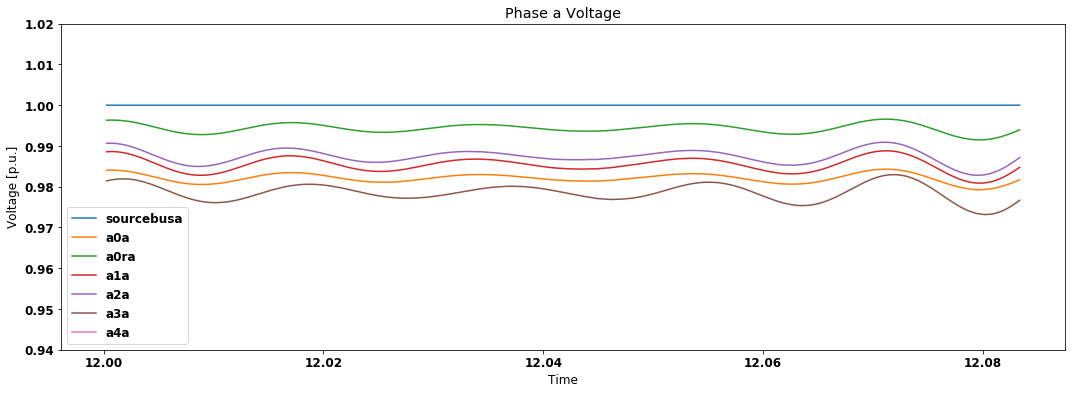

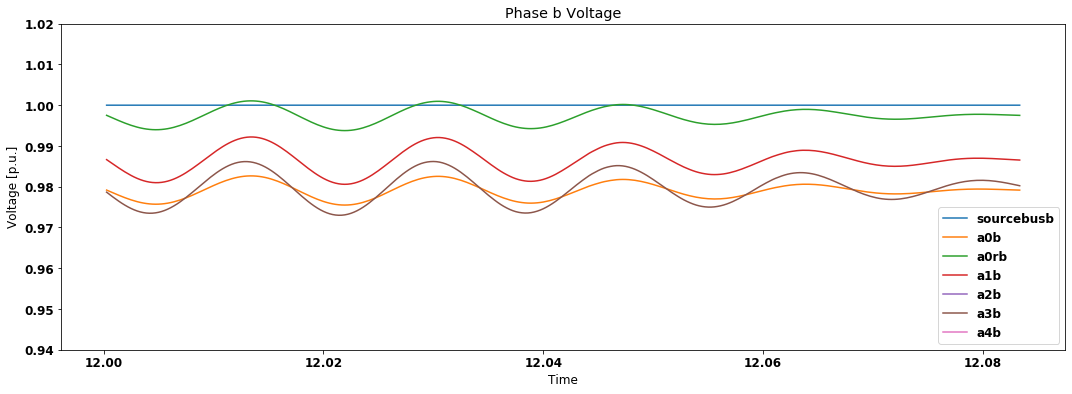

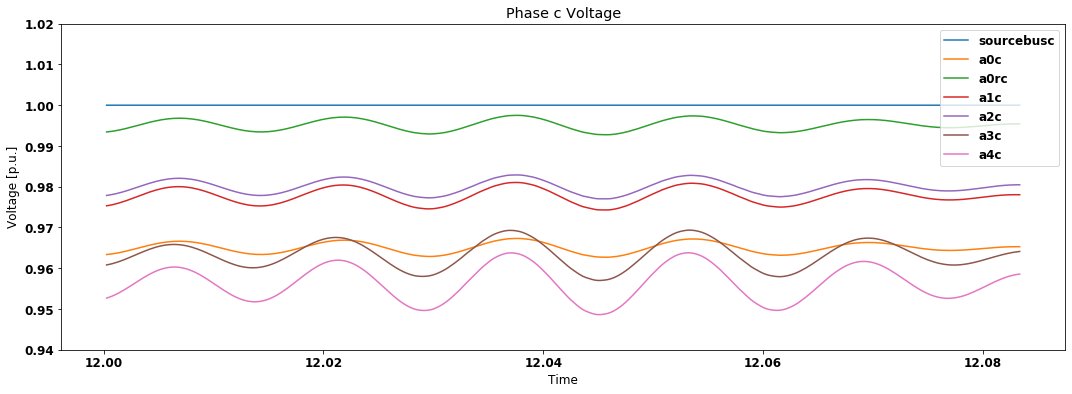

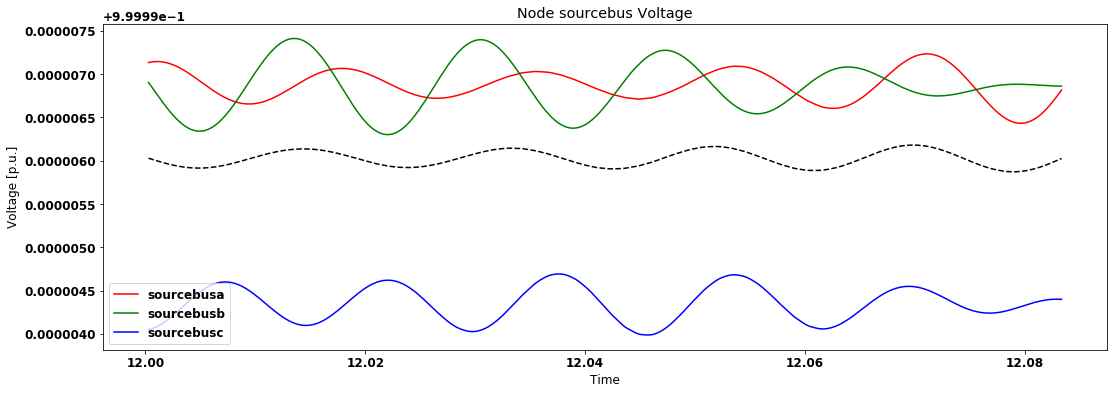

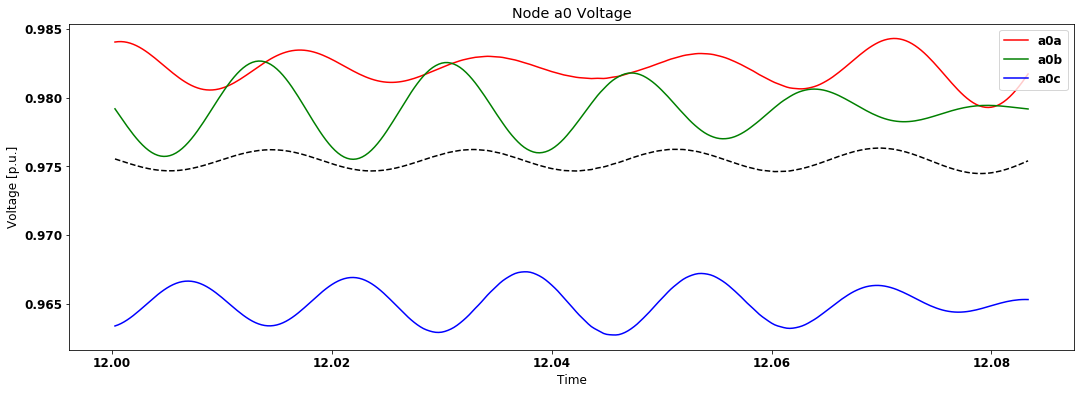

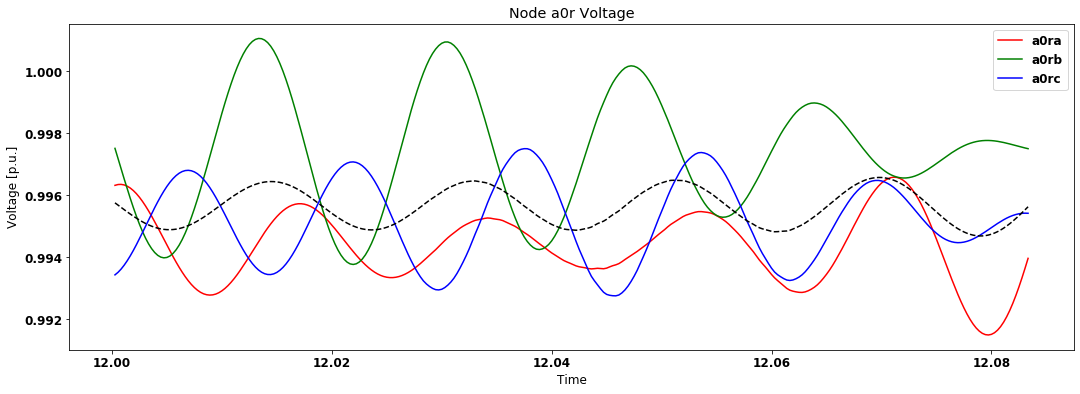

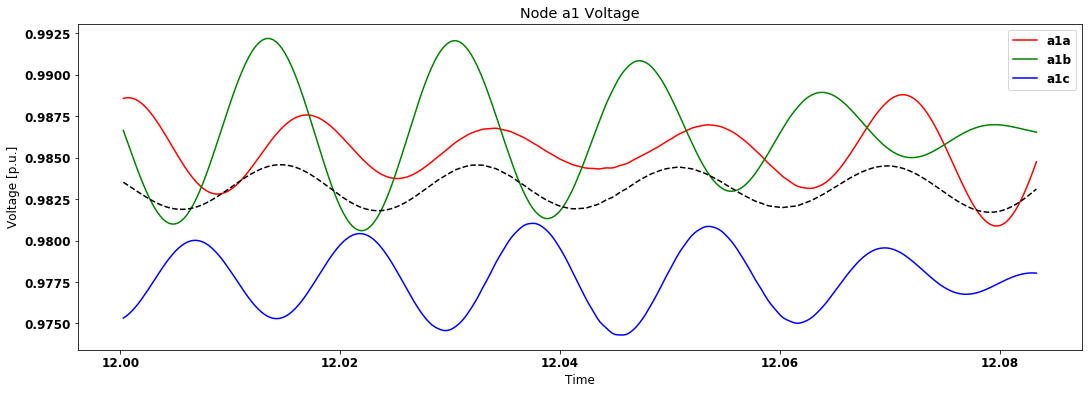

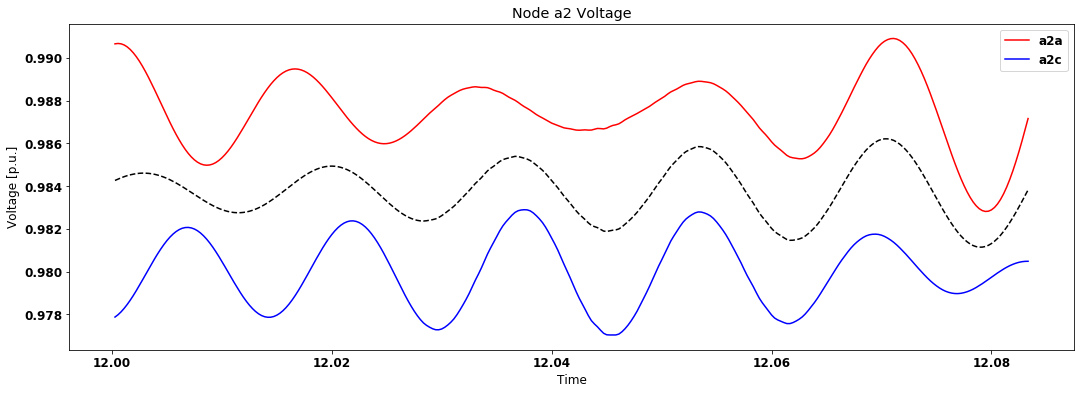

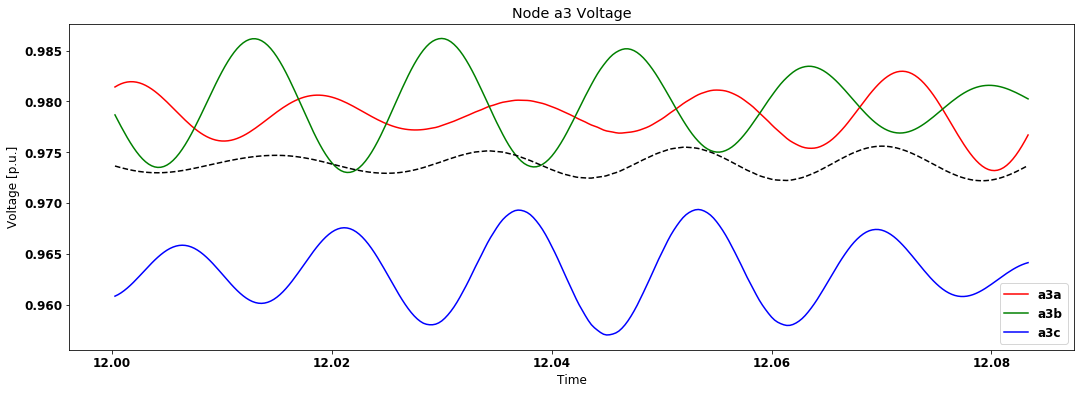

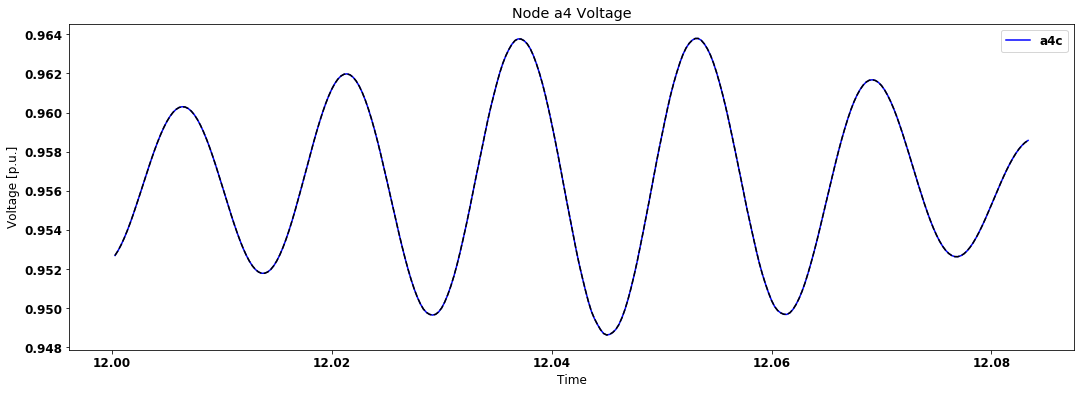

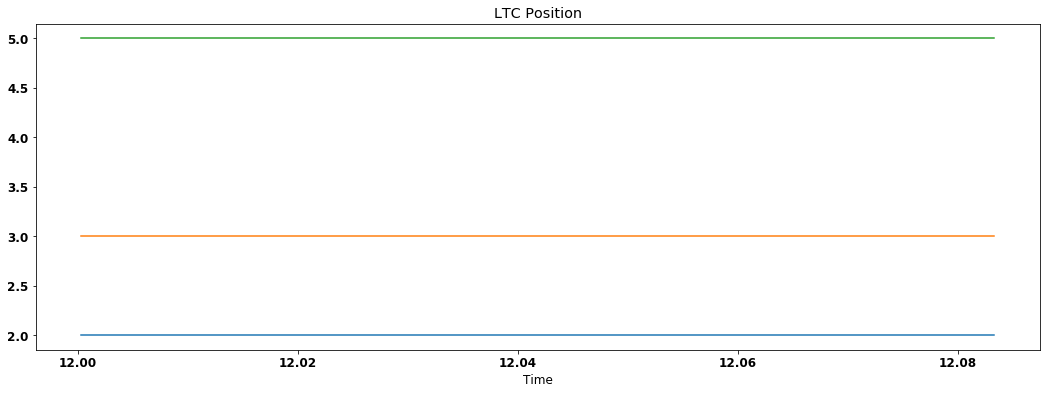

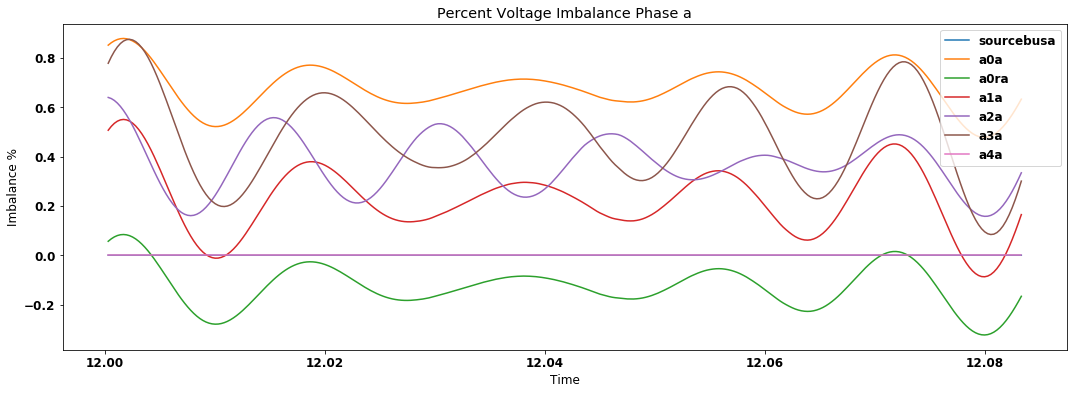

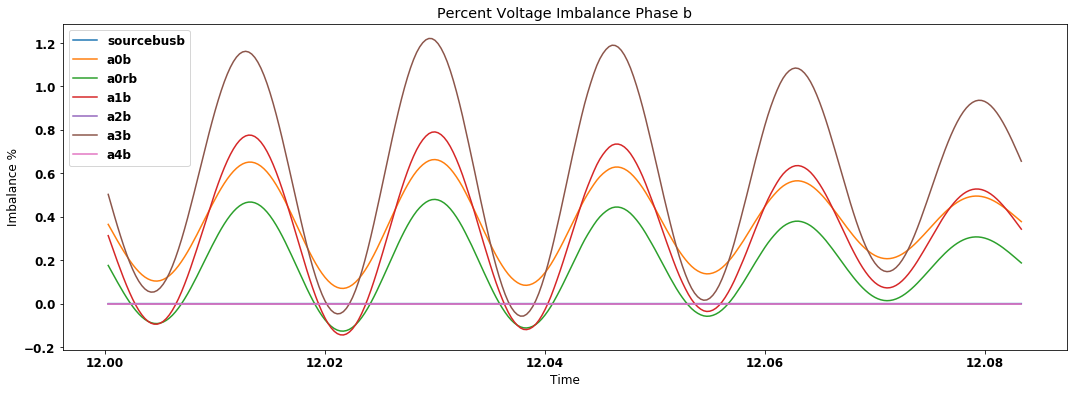

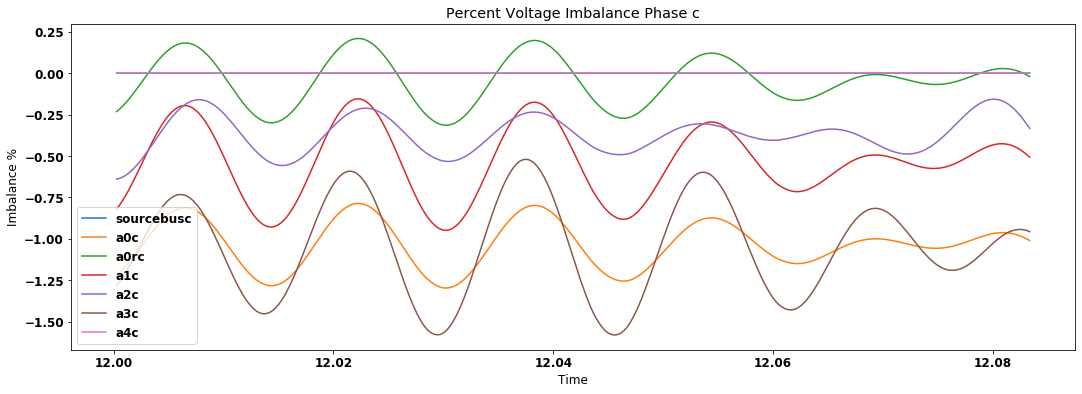

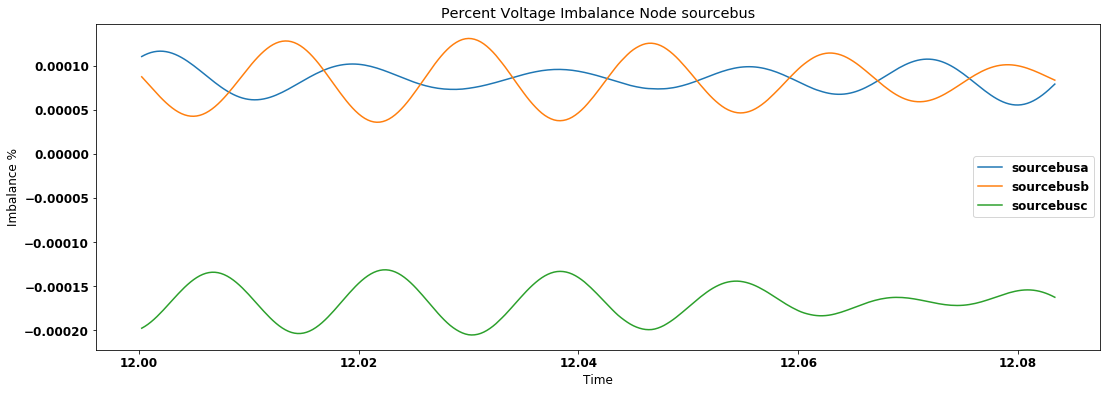

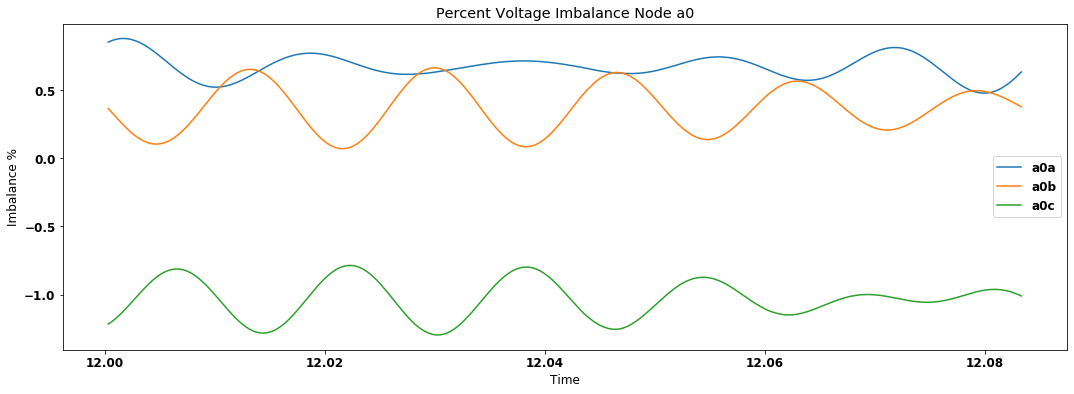

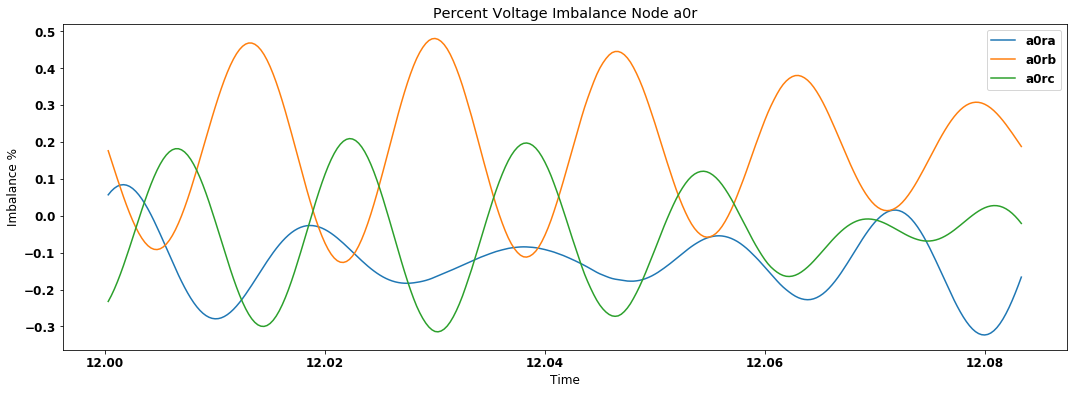

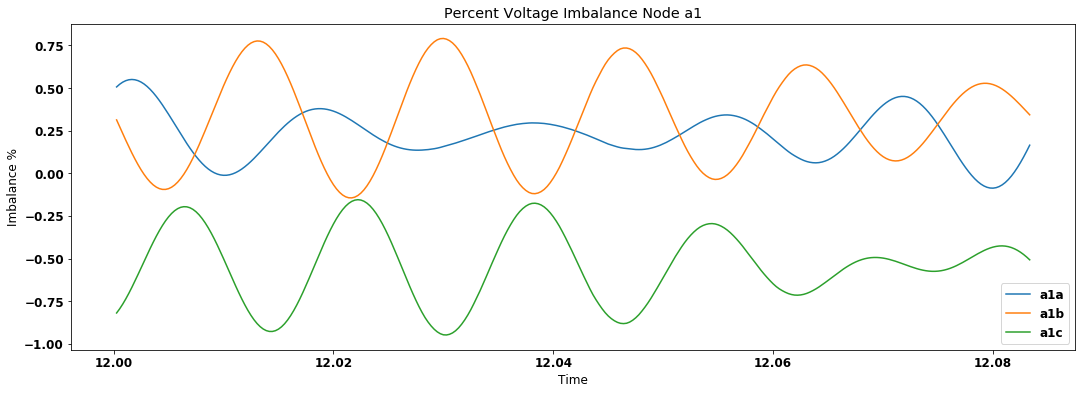

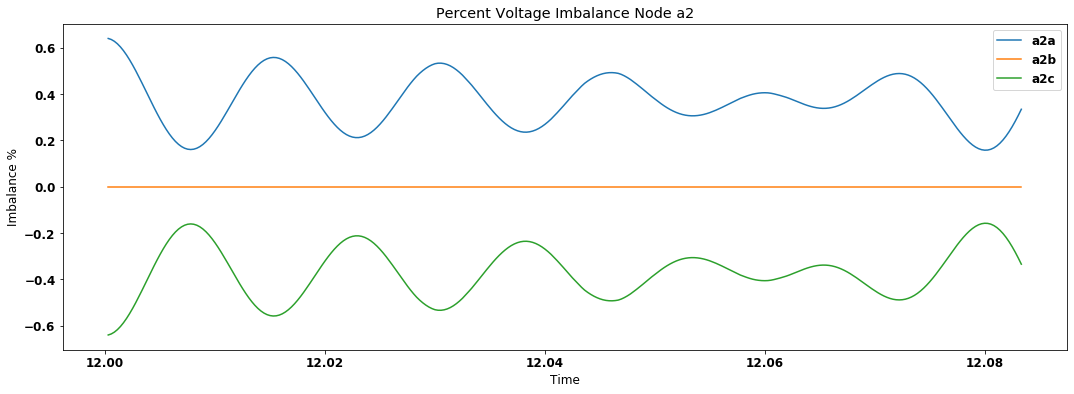

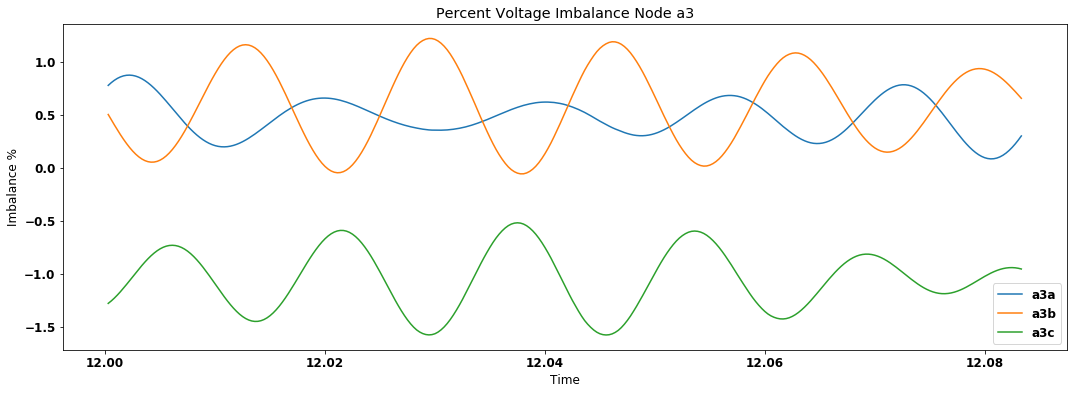

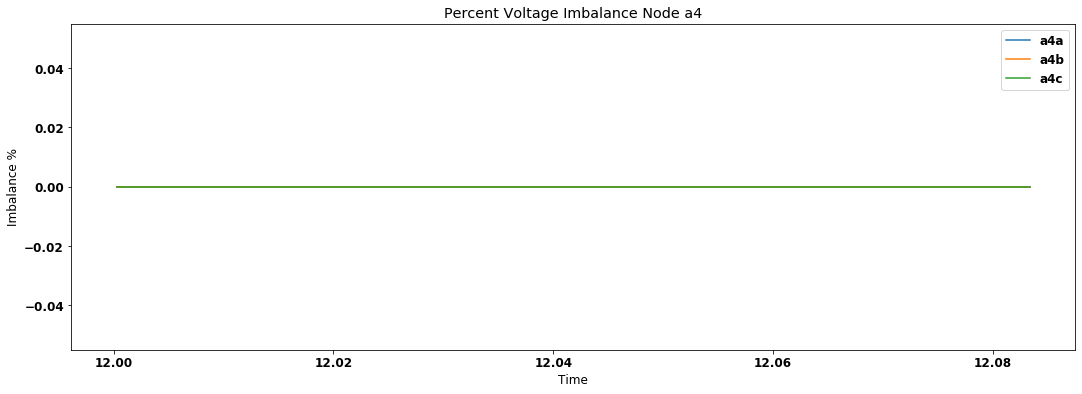

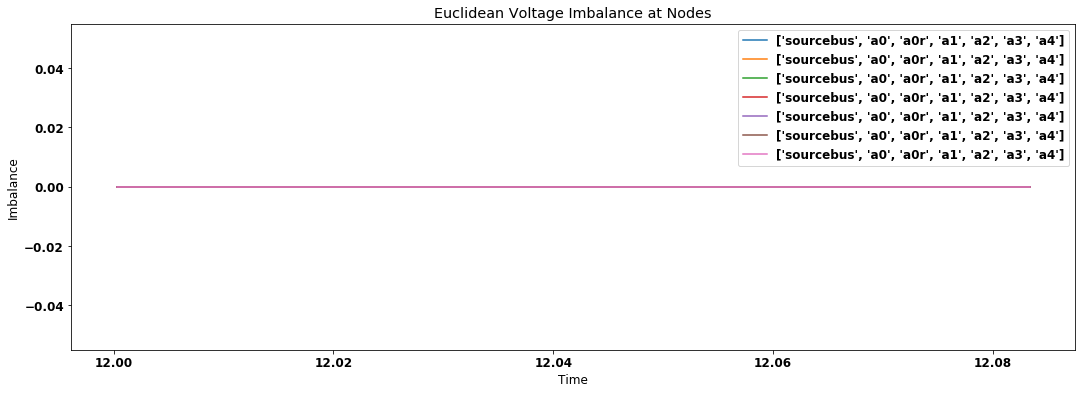

In [59]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

# fig = plt.figure(figsize=[12,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(LoadBuses)):
# #     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
#     plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

phlist = ['a','b','c']
phcolor = ['r', 'g', 'b']


# fig = plt.figure(figsize=[18,6])
# for phnum in range(0,3):
#     plt.subplot(1,3,phnum+1)
#     for k1 in range(len(AllBuses)):        
#         plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
#     plt.legend()
#     plt.title('Node Voltage Phase ' + phlist[phnum])
#     plt.xlabel('Time')
#     plt.ylabel('Voltage [p.u.]')
# plt.show()


for phnum in range(0,3):
    fig = plt.figure(figsize=[18,6])
    for k1 in range(0,len(AllBuses)):
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Phase ' +  phlist[phnum] + ' Voltage')
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
    plt.ylim(0.94, 1.02)
plt.show()

for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    idx = np.array(dss.Bus.Nodes()) - 1
    fig = plt.figure(figsize=[18,6])
    for k2 in range(0,len(idx)):
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,idx[k2],k1],phcolor[idx[k2]],label=AllBuses[k1]+phlist[idx[k2]])
    plt.plot(time/3600,np.mean(AllBusVoltage[plotStartTimeStep:plotEndTimeStep,idx,k1],axis=1),'k--')
    plt.legend()
    plt.title('Node ' +  AllBuses[k1] + ' Voltage')
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,TapPos[plotStartTimeStep:plotEndTimeStep])
# plt.legend()
plt.title('LTC Position')
plt.xlabel('Time')
plt.show()

# fig = plt.figure(figsize=[18,6])
# for phnum in range(0,3):
#     plt.subplot(1,3,phnum+1)
#     for k1 in range(len(AllBuses)):        
#         plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
#     plt.legend()
#     plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
#     plt.xlabel('Time')
#     plt.ylabel('Imbalance %')
# plt.show()

for phnum in range(0,3):
    fig = plt.figure(figsize=[18,6])
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
plt.show()

for k1 in range(len(AllBuses)):
    fig = plt.figure(figsize=[18,6])
    for phnum in range(0,3):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Node ' + AllBuses[k1])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,Voltage_Imbalance_02[plotStartTimeStep:plotEndTimeStep],label=AllBuses)
plt.title('Euclidean Voltage Imbalance at Nodes')
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

# fig = plt.figure(figsize=[18,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(AllBuses)):
#     for phnum in range(0,3):
#         plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
# #     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
#     plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([0.85, 1.05])
# plt.title('Inverter Low-pass Filter Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
#     plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([-100, 100])
# plt.title('Inverter Reactive Power Output')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Load Demands')
# # plt.xlabel('Time')
# # plt.ylabel('Percent Capacity [%]')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Demand')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Demand [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Demand')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Demand [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Injection')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Injection')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Injection [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Injection')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Injection [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Total')
# # plt.show()

# fig = plt.figure(figsize=[18,6])
# for phnum in range(0,3):
#     plt.subplot(1,3,phnum+1)
#     for k1 in range(len(LoadBuses)):
#         if LoadBuses[k1][-1] == phlist[phnum]:
#             plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
#     plt.title('Load Total Active Power')
#     # plt.xlabel('Time')
#     plt.ylabel('Total Active Power [kW]')
#     plt.legend()
# plt.show()

# fig = plt.figure(figsize=[18,6])
# for phnum in range(0,3):
#     plt.subplot(1,3,phnum+1)
#     for k1 in range(len(LoadBuses)):
#         if LoadBuses[k1][-1] == phlist[phnum]:
#             plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
#     plt.title('Load Total Reactive Power')
#     # plt.xlabel('Time')
#     plt.ylabel('Total Reactive Power [kW]')
#     plt.legend()
# plt.show()



In [ ]:
dss.Circuit.AllBusNames()

In [ ]:
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(dss.Bus.kVBase())

In [ ]:
dss.Bus.Nodes()

In [ ]:
AllBuses[2] != '799'

In [19]:
'assbutt'

'inverter' not in 'inverter_909'

False

In [87]:
for k1 in range(0,len(AllLoads)):
    dss.Loads.Name(AllLoads[k1])
    print(dss.CktElement.BusNames()[0])


a1.1
a1.2
a1.3
a2.1.3
a3.1
a3.2
a3.3
a4.3


In [23]:
len(AllBuses)

7

In [56]:
k1

7

In [63]:
dss.Bus.Nodes()[0]

1

In [67]:

AllBusVoltage[simStartTimeStep+10,:,:]

array([[0.99999566, 0.97373576, 0.99196668, 0.97739972, 0.97698526,
        0.97055953, 0.        ],
       [0.99999612, 0.97443416, 0.99267859, 0.97854935, 0.        ,
        0.97171764, 0.        ],
       [0.99999353, 0.95931295, 0.99524643, 0.97379432, 0.97359086,
        0.96084346, 0.95527664]])

In [68]:
for k1 in range(0,len(AllBuses)):
    print(AllBuses[k1])
    print(AllBusVoltage[simStartTimeStep+10,:,k1])

sourcebus
[0.99999566 0.99999612 0.99999353]
a0
[0.97373576 0.97443416 0.95931295]
a0r
[0.99196668 0.99267859 0.99524643]
a1
[0.97739972 0.97854935 0.97379432]
a2
[0.97698526 0.         0.97359086]
a3
[0.97055953 0.97171764 0.96084346]
a4
[0.         0.         0.95527664]


In [85]:
X = np.arange(0,10)
print(X)

idx = np.array([0, 1, 5])
X[idx]

[0 1 2 3 4 5 6 7 8 9]


array([0, 1, 5])

In [93]:
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    dss.Bus.Nodes()
    print(dss.Bus.Nodes())
    x = np.array(dss.Bus.Nodes())-1
    print(np.array(dss.Bus.Nodes()))
    print(x)

[1, 2, 3]
[1 2 3]
[0 1 2]
[1, 2, 3]
[1 2 3]
[0 1 2]
[1, 2, 3]
[1 2 3]
[0 1 2]
[1, 2, 3]
[1 2 3]
[0 1 2]
[1, 3]
[1 3]
[0 2]
[1, 2, 3]
[1 2 3]
[0 1 2]
[3]
[3]
[2]


In [113]:
dss.Circuit.SetActiveBus(AllBuses[k1])
np.isin(dss.Bus.Nodes(),1)
np.any(np.isin(dss.Bus.Nodes(),1))

True

In [57]:
inverters[1].reactive_power[simStartTimeStep:simStartTimeStep+25]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , -60.24025588, -61.77118301,
       -29.62392152, -17.64831753, -33.80967461, -47.42598992,
       -43.48950951, -33.90013403, -33.05000546, -38.74301986,
       -41.31074167, -38.68461874, -35.75855531, -35.83392721,
       -37.09284534])